# Data processing
Hucul-west blade trap.

In [10]:
!pwd
!which python

import sys
import logging, os
import numpy as np
import matplotlib.pyplot as plt
# from multiprocessing import Pool    # parallel computation.

sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem')   # add path of package "bem" to search list.
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list.

/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples/Hucul-west_3DTrap
/Users/Ben/opt/anaconda3/envs/py3bem/bin/python


In [8]:
# name of vtk files (usually the same as stl file)
prefix = "Hucul-west_20180813_0d1-0d1-5"
suffix = ""

### Read data from VTK files saved by `bem` package

In [9]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 RF1 RF2".split():
    e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)    # classmethod
    e.name = name
    s.append(e)    # class System(list), System inherits list method "append".
# System() class has a "__getitem__() method", so instance s is subscriptable (can use []).
print(s["RF1"],s["RF1"].rf)

ModuleNotFoundError: No module named 'electrode'

### Define ion physical parameters and set electrode voltages

In [4]:
import scipy.constants as ct
l = 200e-6 # length scale
u = 168 # peak rf voltage
o = 34.1e6*2*np.pi # rf frequency
m = 174*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
rf_scale = s.rf_scale(m,q,l,o)

# Set voltages (from brittonlab experiment)
V0 = u
V1,V2 = 5,5
DCvol = {"DC1":V1,"DC2":V2,"DC3":0,"DC4":V2,"DC5":V1,
         "DC6":V1,"DC7":V2,"DC8":0,"DC9":V2,"DC10":V1}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
s["RF1"].rf, s["RF2"].rf = V0, V0    # s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
print("RF1",s["RF1"].rf,"V\nRF2",s["RF2"].rf,"V")

DC3 0 V
DC10 5 V
DC2 5 V
DC8 0 V
DC9 5 V
DC4 5 V
DC6 5 V
DC7 5 V
DC1 5 V
DC5 5 V
RF1 168 V
RF2 168 V


### Trap parameters

In [5]:
# Search minimum and print trap parameters such as secular frequency
xi = (0., 0., 0.)
# Use 'Nelder-Mead'/'Powell'/'L-BFGS-B' method for minimum() if a precision loss error occurs.
# Default is 'Newton-CG'.
method = 'L-BFGS-B'    # Cautious! Different methods may lead to slight different minimums (error~grid step).
x0 = s.minimum(xi, method=method)
# x0 = np.array([0.2,0.0,0.0])
print("minimum x0:",x0)
print("minimum offset: {}\n".format(x0-xi))
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o, min_off=False, min_method=method):
    print(line)

minimum x0: [ 0.22616163 -0.03219982 -0.03303941]
minimum offset: [ 0.22616163 -0.03219982 -0.03303941]

parameters:
 f=34.1 MHz, m=174 amu, q=1 qe, l=200 µm, scale=0.00869 V'/V_SI
corrdinates:
 analyze point: [ 0.22616163 -0.03219982 -0.03303941]
               ([ 45.23232549  -6.43996438  -6.60788129] µm)
 minimum is at offset: [ 0.  0.  0.]
                      ([ 0.  0.  0.] µm)
potential:
 dc electrical: 0.86 eV
 rf pseudo: 4.3e-07 eV
 saddle offset: [  1.84341971e-06   8.41915639e-07  -1.53099650e-07]
               ([  3.68683942e-04   1.68383128e-04  -3.06199299e-05] µm)
 saddle height: 9.4e-08 eV
force:
 dc electrical: [ -3.79188722e-06   1.40025538e-03   3.23969441e-04] eV/l
               ([-0.01895944  7.00127688  1.61984721] eV/m)
 rf pseudo: [  7.71347727e-07  -1.39972642e-03  -3.22884976e-04] eV/l
           ([  3.85673863e-03  -6.99863208e+00  -1.61442488e+00] eV/m)
modes:
 pp+dc normal curvatures: [ 1.00974533  1.638866    2.53460432]
 motion is bounded: False
 pseudo

/home/wwc/anaconda3/envs/ele35/lib/python3.5/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


### Create plotting grid from VTK

In [6]:
from electrode import Grid
# find minimum x0 and saddle point xs
xi = (0., 0., 0.)
x0 = s.minimum(xi,method=method)
xs, xsp = s.saddle(x0+1e0*x0)    # 1e0*x0, intenally introduce an offset to search saddle around x0
print("Minimum x0/l: {}".format(x0))
print("Saddle xs/l: {}\nSaddle height: {}".format(xs,xsp))

# extract grid infomation from one GridElectrode instance (s[0])
step, shape = s[0].spacing, np.array(s[0].data[0].shape[:-1])
center = s[0].origin + (shape-1)*step/2
print("\ncenter/l: {}".format(center))
# shape = np.array(shape)/2    # original shapes are too large, only interest in trap region
# locate center a little higher than x0 (or plot would include electrodes)
gridx = Grid(x0+np.array([0, 0, 0.2]), step, shape)
gridy = Grid(x0+np.array([0, 0, 0.2]), step, shape)

Minimum x0/l: [ 0.22616163 -0.03219982 -0.03303941]
Saddle xs/l: [ 0.2248183  -0.35207839 -0.78276014]
Saddle height: 1.1382327071763112

center/l: [  1.11022302e-16   1.11022302e-16   1.11022302e-16]


/home/wwc/anaconda3/envs/ele35/lib/python3.5/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


max, min potential: 9.191670, 0.001313
max, min potential: 1.768396, 0.860411


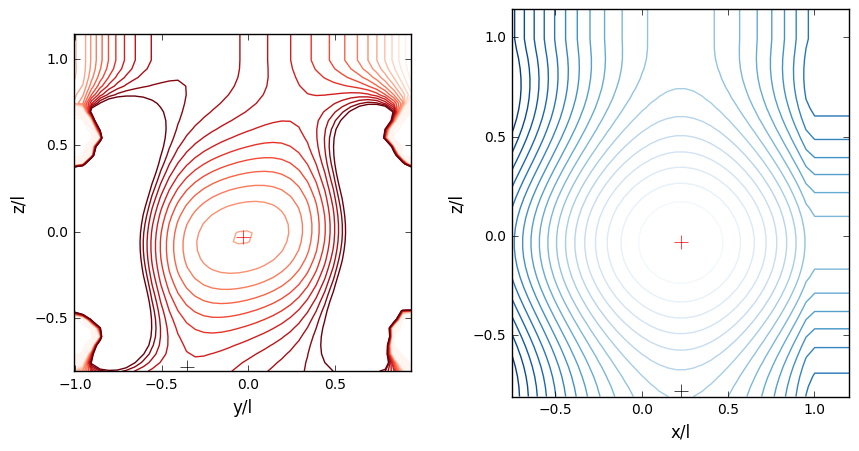

In [7]:
fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.3},figsize=(10,5),dpi=100)
ax[0].set_aspect("equal")
# plot_contour() in System class.
# choose divide_max smaller than but close to max potential, or divide_max=-1
s.plot_contour(ax[0],grid=gridx,slc='x',slc_at=x0[0],divide_max=7,line_num=30,cmap=plt.cm.Reds)
s.plot_contour(ax[1],grid=gridy,slc='y',slc_at=x0[2],divide_max=1,line_num=20,cmap=plt.cm.Blues)
# plot minimum and saddle points with contour plot
ax[0].plot(x0[1],x0[2],'r+',markersize=10)    # red
ax[0].plot(xs[1],xs[2],'k+',markersize=10)    # black
ax[1].plot(x0[0],x0[2],'r+',markersize=10)
ax[1].plot(xs[0],xs[2],'k+',markersize=10)

In [8]:
# To understand the data structure of GridElectrode.data.
# print(e.origin, e.spacing)
# print(len(e.data),type(e.data))  # [pot_array,field_array,2nd_pot_array,3rd_pot_array], 0~3,4th derivative order.
# print(type(e.data[0]),type(e.data[1]))  # All list elements are ndarray.
# print(e.data[0].shape,e.data[1].shape)    # (nx,ny,nz,components)
# print(e.data[0])    # potential
# # [[[[p(x0,y0,z0)],
# #    [p(x0,y0,z1)],
# #    [p(x0,y0,z2)]],
# #    
# #   [[p(x0,y1,z0)],
# #    [p(x0,y1,z1)],
# #    [p(x0,y1,z2)]],     
# #
# #   ]]

Plot the horizontal logarithmic pseudopotential at the ion height and the logarithmic pseudopotential and the separatrix in the xz plane.

ValueError: ('%s', ((array([ 0.23616163, -0.02219982, -0.02303941]), [0, 1, 2], array([ 0.50603181,  0.18580422,  0.10479805]), array([ 0.50603181,  0.18580422,  0.10479805]), 0.96096823325119884, 'iter'),))

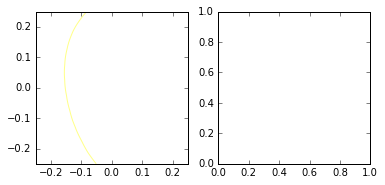

In [9]:
from electrode import shaped
n, h, d = 50, 1/8., 1/4.
xyz = np.mgrid[-d:d:1j*n, -d:d:1j*n, h:h+1]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect="equal"))
pot = shaped(s.potential)(xyz)
v = np.arange(-15, 3)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
ax[0].contour(x, y, np.log2(p), v, cmap=plt.cm.hot)

(xs1, ps1), (xs0, ps0) = s.saddle(x0+1e-2), s.saddle([0, 0, .8])
print("main saddle:", xs0, ps0)
xyz = np.mgrid[-d:d:1j*n, 0:1, .7*h:3*h:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
ax[1].contour(x, z, np.log2(p), v, cmap=plt.cm.hot)
ax[1].contour(x, z, np.log2(p), np.log2((ps1, ps0)), color="black")